## Chapter 19.1 What is Hyperparameter Optimization?

In [1]:
import numpy as np
import torch
from scipy import stats
from torch import nn
from d2l import torch as d2l

In [2]:
class HPOTrainer(d2l.Trainer):
    def validation_error(self):
        self.model.eval()
        accuracy = 0
        val_batch_idx = 0
        for batch in self.val_dataloader:
            with torch.no_grad():
                x, y = self.prepare_batch(batch)
                y_hat = self.model(x)
                accuracy += self.model.accuracy(y_hat, y)
            val_batch_idx += 1
        return 1 - accuracy / val_batch_idx

In [3]:
def hpo_objective_softmax_classification(config, max_epochs=8):
    learning_rate = config["learning_rate"]
    trainer = d2l.HPOTrainer(max_epochs=max_epochs)
    data = d2l.FashionMNIST(batch_size=16)
    model = d2l.SoftmaxRegression(num_outputs=10, lr=learning_rate)
    trainer.fit(model=model, data=data)
    return trainer.validation_error().detach().numpy()

In [4]:
config_space = {"learning_rate": stats.loguniform(1e-4, 1)}

       validation_error = 0.22670000791549683


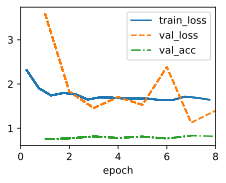

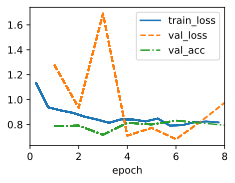

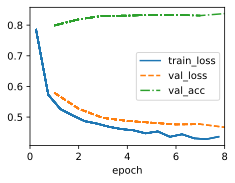

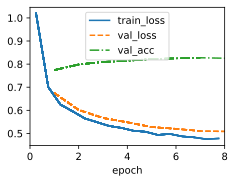

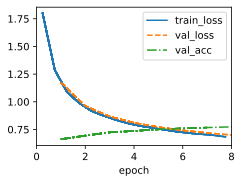

In [5]:
errors, values = [], []
num_iterations = 5

for i in range(num_iterations):
    learning_rate = config_space["learning_rate"].rvs()
    print(f'Trial {i}: learning_rate = {learning_rate}')
    y = hpo_objective_softmax_classification({"learning_rate": learning_rate})
    print(f'       validation_error = {y}')
    values.append(learning_rate)
    errors.append(y)

In [6]:
best_idx = np.argmin(errors)
print(f'optimal learning rate = {values[best_idx]}')

optimal learning rate = 0.012447639190580237


## Chatper 19.2 Hyperparameter Optimization API

In [7]:
import time
from scipy import stats
from d2l import torch as d2l

In [8]:
class HPOSearcher(d2l.HyperParameters):
    def sample_configuration() -> dict:
        raise NotImplementedError
        
    def update(self, config: dict, error: float, additional_info=None):
        pass

In [9]:
class RandomSearcher(HPOSearcher):
    
    def __init__(self, config_space: dict, initial_config=None):
        self.save_hyperparameters()
        
    def sample_configuration(self) -> dict:
        if self.initial_config is not None:
            result = self.initial_config
            self.initial_config = None
        else:
            result = {
                name: domain.rvs()
                for name, domain in self.config_space.items()
            }
        return result

In [10]:
class HPOScheduler(d2l.HyperParameters):
    def suggest(self) -> dict:
        raise NotImplementedError
        
    def update(self, config: dict, error: float, info=None):
        raise NotImplementedError

In [11]:
class BasicScheduler(HPOScheduler):
    
    def __init__(self, searcher: HPOSearcher):
        self.save_hyperparameters()
        
    def suggest(self) -> dict:
        return self.searcher.sample_configuration()
    
    def update(self, config: dict, error: float, info=None):
        self.searcher.update(config, error, additional_info=info)

In [18]:
class HPOTuner(d2l.HyperParameters):
    
    def __init__(self, scheduler: HPOScheduler, objective: callable):
        self.save_hyperparameters()
        
        self.incumbent = None
        self.incumbent_error = None
        self.incumbent_trajectory = []
        self.cumulative_runtime = []
        self.current_runtime = 0
        self.records = []
        
    def run(self, number_of_trials):
        for i in range(number_of_trials):
            start_time = time.time()
            config = self.scheduler.suggest()
            print(f'Trial {i}: config = {config}')
            error = self.objective(**config)
            error = float(error.cpu().detach().numpy())
            self.scheduler.update(config, error)
            runtime = time.time() - start_time
            self.bookkeeping(config, error, runtime)
            print(f'      error = {error}, runtime = {runtime}')
            
    def bookkeeping(self, config: dict, error: float, runtime: float):
        self.records.append({'config': config, 'error': error, 'runtime': runtime})
        
        if self.incumbent is None or self.incumbent_error > error:
            self.incumbent = config
            self.incumbent_error = error
            
        self.incumbent_trajectory.append(self.incumbent_error)
        
        self.current_runtime += runtime
        self.cumulative_runtime.append(self.current_runtime)

In [19]:
# Example: Optimizing the Hyperparameters of a CNN

def hpo_objective_lenet(learning_rate, batch_size, max_epochs=10):
    model = d2l.LeNet(lr=learning_rate, num_classes=10)
    trainer = d2l.HPOTrainer(max_epochs=max_epochs, num_gpus=1)
    data = d2l.FashionMNIST(batch_size=batch_size)
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
    trainer.fit(model=model, data=data)
    validation_error = trainer.validation_error()
    return validation_error

In [20]:
config_space = {
    "learning_rate": stats.loguniform(1e-2, 1),
    "batch_size": stats.randint(32, 256),
}

initial_config = {
    "learning_rate": 0.1,
    "batch_size": 128
}

      error = 0.2944445013999939, runtime = 55.72446870803833


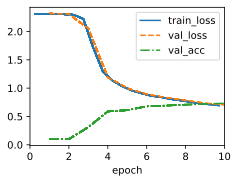

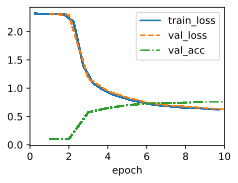

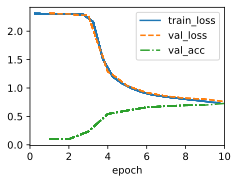

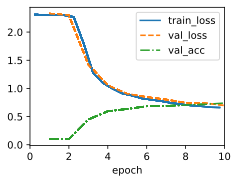

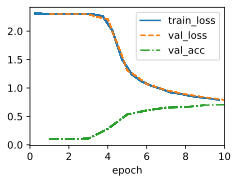

In [21]:
searcher = RandomSearcher(config_space, initial_config=initial_config)
scheduler = BasicScheduler(searcher=searcher)
tuner = HPOTuner(scheduler=scheduler, objective=hpo_objective_lenet)
tuner.run(number_of_trials=5)

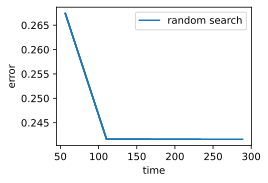

In [22]:
board = d2l.ProgressBoard(xlabel="time", ylabel="error")
for time_stamp, error in zip(
    tuner.cumulative_runtime, tuner.incumbent_trajectory):
    board.draw(time_stamp, error, 'random search', every_n=1)

## Chapter 19.3 Asynchronous Random Search

In [24]:
import logging
from d2l import torch as d2l

In [ ]:
# Syne Tune: Large-Scale and Reproducible Hyperparameter Optimization

In [32]:
!pip install -U syne-tune[aws]

In [33]:
logging.basicConfig(level=logging.INFO)
from syne_tune import StoppingCriterion, Tuner
from syne_tune.backend.python_backend import PythonBackend
from syne_tune.config_space import loguniform, randint
from syne_tune.experiments import load_experiment
from syne_tune.optimizer.baselines import RandomSearch

ImportError: cannot import name 'PythonBackend' from 'syne_tune.backend.python_backend' (/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/syne_tune/backend/python_backend/__init__.py)